In [1]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



2026-01-30 23:37:40.264458: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-30 23:37:40.278535: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-30 23:37:40.744877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-30 23:37:41.966053: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
df = pd.read_csv("../data/labels.csv")
df['image_path'] = df['image_path'].apply(lambda x: os.path.abspath(os.path.join("..", x)))


In [3]:
label_map = {"Focused":0, "Drifting":1, "Lost":2}
inv_label_map = {v:k for k,v in label_map.items()}
df['label_idx'] = df['label'].map(label_map)

In [4]:
from sklearn.model_selection import train_test_split
_, test_df = train_test_split(df, test_size=0.15, stratify=df['label_idx'], random_state=42)
print(f"Test samples: {len(test_df)}")


Test samples: 318


In [6]:
model = load_model('../outputs/models/focus_model.h5') 

E0000 00:00:1769812716.449546    8721 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1769812716.455299    8721 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224,224),
    class_mode='categorical',
    shuffle=False
)

Found 318 validated image filenames belonging to 3 classes.


In [8]:
# Predict 
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step


In [9]:
print(classification_report(y_true, y_pred, target_names=list(label_map.keys())))


              precision    recall  f1-score   support

     Focused       0.88      0.95      0.92       109
    Drifting       1.00      1.00      1.00        52
        Lost       0.97      0.91      0.94       157

    accuracy                           0.94       318
   macro avg       0.95      0.95      0.95       318
weighted avg       0.94      0.94      0.94       318



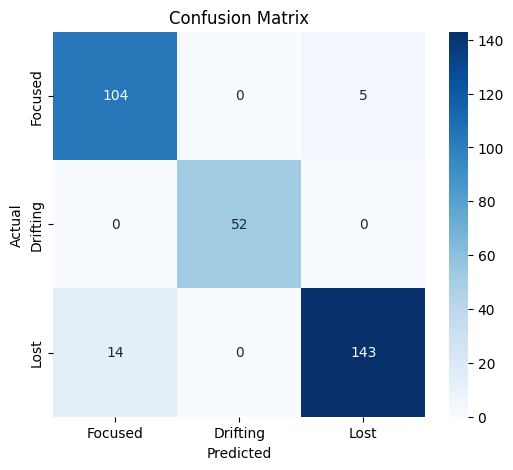

In [10]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()